## **INTRODUCTION ⛩**


Predicting health insurance costs accurately has significant implications for the healthcare and insurance fields, and its importance in today's world can be highlighted in several ways.


Accurate prediction of health insurance costs allows insurance companies and healthcare providers to estimate and plan their financial resources effectively. This ensures better budgeting and financial stability, ultimately contributing to the sustainability of healthcare services.
inancial Planning:


* Ensures that people pay fair and competitive insurance premiums based on their expected healthcare costs.

* Enables better identification and management of risks associated with policyholders, leading to more targeted coverage and pricing.

* Provides a better experience for policyholders by avoiding unexpected financial surprises.

* Helps insurance companies comply with regulations, ensuring fair practices.

* Aids in efficient allocation of resources in healthcare, benefiting both providers and patients.

* Contributes to a more efficient and sustainable healthcare system overall.


## **Gap in the Knowledge and Future Purposes 💡**

"Upon reviewing the dataset, it's evident that the number of variables available for predicting the target variable is limited. To address this, we can consider gathering more data to enhance the model's predictive capabilities. This could involve introducing new variables related to pre-existing conditions, specific medical treatments, or socioeconomic factors, providing a more comprehensive understanding of the individuals in the dataset.

Moreover, considering external data sources, such as demographic data, regional healthcare statistics, or lifestyle indices, could further enrich our analysis. This broader dataset not only improves the current model but also future-proofs it against changing trends and evolving healthcare landscapes. It serves as a template for future projects, allowing for a structured and efficient approach to data analysis and modeling.

 Overall, this approach lays the groundwork for a more robust and adaptable solution, aligning with best practices in data science."

In [77]:
# importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib

In [78]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 11


In [79]:
# loading the dataset
df=pd.read_excel('/content/Health_insurance_cost (1).xlsx')
df

,age,gender,BMI,Children,smoking_status,location,health_insurance_price
0,19.0,female,NaN,0,yes,southwest,16884.92400
1,18.0,male,33.770,1,no,southeast,1725.55230
2,28.0,male,33.000,3,no,southeast,4449.46200
3,33.0,male,22.705,0,no,northwest,21984.47061
4,32.0,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50.0,male,30.970,3,no,northwest,10600.54830
1334,18.0,female,31.920,0,no,northeast,2205.98080
1335,18.0,female,36.850,0,no,southeast,1629.83350
1336,21.0,female,25.800,0,no,southwest,2007.94500


## **Data Cleaning 🧹**

In [80]:
df.info() #checking the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     1310 non-null   float64
 1   gender                  1338 non-null   object 
 2   BMI                     1315 non-null   float64
 3   Children                1338 non-null   int64  
 4   smoking_status          1338 non-null   object 
 5   location                1338 non-null   object 
 6   health_insurance_price  1336 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 73.3+ KB


In [81]:
df["location"].value_counts()                     # gender,smoking status,location are columns with limited number of unique values so it is good to convert it to categorical instead of float64

southeast    364
southwest    325
northwest    325
northeast    324
Name: location, dtype: int64

In [82]:
# converting to categorical

ct_data=['gender','smoking_status','location']

df[ct_data]=df[ct_data].astype("category")

In [83]:
df.describe() # from this we might assume that most of the variables are mormally distributed

,age,BMI,Children,health_insurance_price
count,1310.000000,1315.000000,1338.000000,1336.000000
mean,39.166412,30.638217,1.094918,13268.527719
std,14.055378,6.110302,1.205493,12112.797724
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.210000,0.000000,4744.325050
50%,39.000000,30.305000,1.000000,9382.033000
75%,51.000000,34.580000,2.000000,16604.302645
max,64.000000,53.130000,5.000000,63770.428010


In [84]:
df.isnull().sum()

age                       28
gender                     0
BMI                       23
Children                   0
smoking_status             0
location                   0
health_insurance_price     2
dtype: int64

In [85]:
df['age']=df['age'].fillna(df['age'].median())   # filling out the null values in age with median as it is not strongly related to other variables.
df['health_insurance_price']=df['health_insurance_price'].fillna(df['health_insurance_price'].median()) # since it is a target variable and to avoid data leakage we go for median imputation

In [86]:
from sklearn.impute import KNNImputer
# Initialize KNNImputer
knn_imputer = KNNImputer(n_neighbors=3)
# Create a DataFrame with columns relevant for KNN imputation
df_knn = df[['BMI', 'age', 'Children']]
# Perform KNN imputation on the selected columns
df_imputed_knn = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)

df['BMI']=df['BMI'].fillna(df_imputed_knn['BMI'])


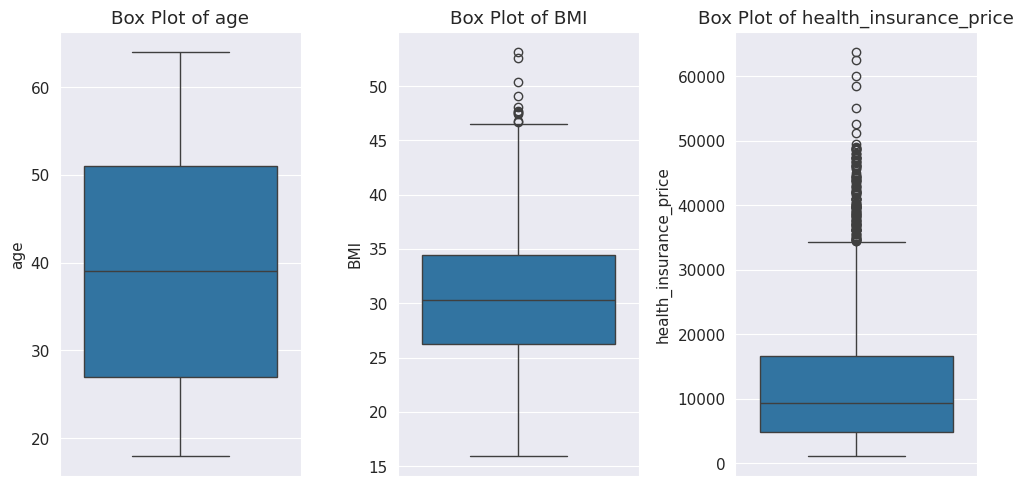

In [87]:
# Outlier detection
col = ["age", "BMI", "health_insurance_price"]

# Set up subplots
plt.figure(figsize=(10, 5))

for i, feature in enumerate(col, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=feature, data=df)
    plt.title(f'Box Plot of {feature}')

plt.tight_layout()
plt.show()


In [88]:
df[df.duplicated()]

,age,gender,BMI,Children,smoking_status,location,health_insurance_price
581,19.0,male,30.59,0,no,northwest,1639.5631


In [89]:
# dropping the duplicate
df.drop_duplicates(keep='first',inplace=True)

In [90]:
# clipping outlier - function creation
def outlier_clipper(df,column):
  q1=df[column].quantile(0.25)
  q3=df[column].quantile(0.75)

  iqr=q3-q1

  lowerlimit=q1-1.5*iqr
  upperlimit=q3+1.5*iqr


  df[column]=df[column].clip(lowerlimit,upperlimit,axis=1)
  return df[column]

col=['BMI','health_insurance_price']
outlier_clipper(df,col)

,BMI,health_insurance_price
0,24.760,16884.92400
1,33.770,1725.55230
2,33.000,4449.46200
3,22.705,21984.47061
4,28.880,3866.85520
...,...,...
1333,30.970,10600.54830
1334,31.920,2205.98080
1335,36.850,1629.83350
1336,25.800,2007.94500


## **EDA 🔍**

In [91]:
df

,age,gender,BMI,Children,smoking_status,location,health_insurance_price
0,19.0,female,24.760,0,yes,southwest,16884.92400
1,18.0,male,33.770,1,no,southeast,1725.55230
2,28.0,male,33.000,3,no,southeast,4449.46200
3,33.0,male,22.705,0,no,northwest,21984.47061
4,32.0,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50.0,male,30.970,3,no,northwest,10600.54830
1334,18.0,female,31.920,0,no,northeast,2205.98080
1335,18.0,female,36.850,0,no,southeast,1629.83350
1336,21.0,female,25.800,0,no,southwest,2007.94500


**UNIVARIATE ANALYSIS 🧍🏻‍♂️**

<Axes: xlabel='BMI', ylabel='Count'>

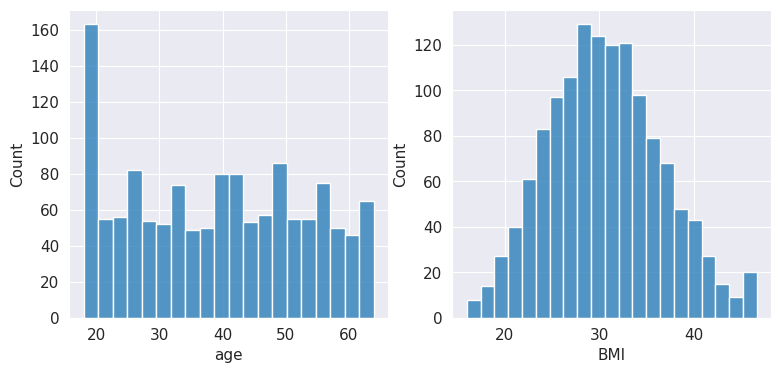

In [92]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
sns.histplot(df['age'],bins=20)

plt.subplot(1,3,2)
sns.histplot(df['BMI'])

1.The distribution of ages in the dataset is almost uniform,except for the ages below 20, which seem to have over twice as many customers as other ages.

**Insight**:
people who are younger are less prone to getting sick and thus company has to pay them less for their medical bills.

2.The measurements of body mass index seem to form a normal distribution centered around the value 30, with a few outliers towards the right.

In [93]:
fig=px.histogram(df,x="health_insurance_price",color='smoking_status',color_discrete_sequence=['red', 'green'])
fig.update_layout(bargap=0.4,width=1500,height=400)
fig

For most customers, the annual medical charges are under 15k, Only a small fraction of customer have higher medical expenses

here is a significant difference in medical expenses between smokers and non-smokers

<Axes: xlabel='Children', ylabel='count'>

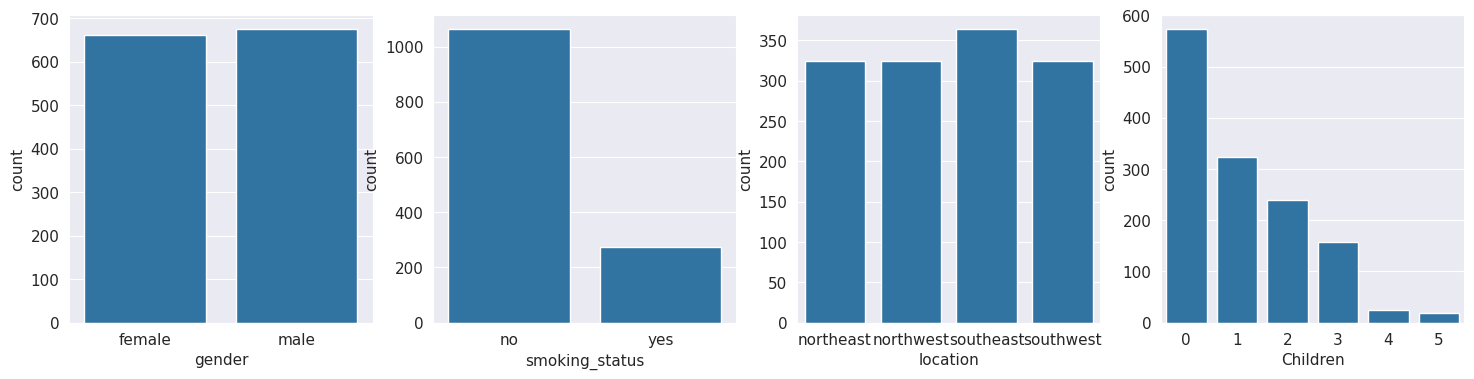

In [94]:
plt.figure(figsize=(18,4))
plt.subplot(1,4,1)
sns.countplot(x=df['gender'])
plt.subplot(1,4,2)
sns.countplot(x=df['smoking_status'])
plt.subplot(1,4,3)
sns.countplot(x=df['location'])
plt.subplot(1,4,4)
sns.countplot(x=df['Children'])

1.The distribution of males and females in the dataset is approximately equal, with only a slight difference in counts between the two genders.

2."The dataset reveals a significant disparity in smoking habits, with the number of smokers comprising only a small fraction of the total population compared to the much larger count of non-smokers."

3.The distribution of location in the dataset is approximately equal,with a slight difference in south east location.

4.The majority of individuals in the dataset have either 0 or 1 child, with a moderate number having 2 or 3 children. However, the counts decrease significantly for families with 4 or 5 children, indicating that these family sizes are relatively uncommon.

D**istributions of the "gender", "location" and "children" columns in relation to health_insurance_price**

In [95]:
fig= px.histogram(df,x='health_insurance_price',color="gender")
fig.update_layout(bargap=0.1,width=1000,height=400)
fig

In the distribution of charges over gender, it's evident that males incur substantially higher charges compared to females.

In [96]:
fig= px.histogram(df,x='health_insurance_price',color="location")
fig.update_layout(bargap=0.1,width=1000,height=400)
fig

 majority of all health_insurance_price  are charged between 0-15k.

In [97]:
fig= px.histogram(df,x='health_insurance_price',color="Children")
fig.update_layout(bargap=0.1,width=800,height=500)
fig

we can barely see family with 4 or 5 childrens, We can also conclude that people who have less children are have low insurance cost than the family with more.

In [98]:
# lets see who smokes the most

fig=px.histogram(df,x="smoking_status",color='gender')
fig.update_layout(bargap=0.1,width=600,height=400)
fig

Among non-smokers : the distribution is nearly equal between genders, However

Among smokers     : there is a slight predominance of males.

**Bivariate analysis 👫**

<Axes: xlabel='BMI', ylabel='health_insurance_price'>

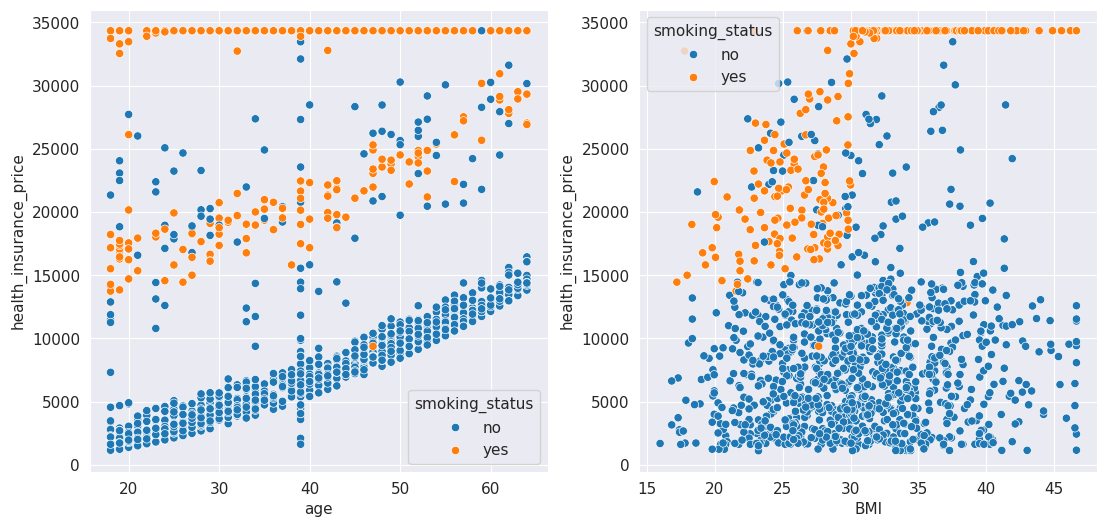

In [99]:
#Bivariate analysis

plt.figure(figsize=(13,6))
plt.subplot(1,2,1)
sns.scatterplot(df,x='age',y='health_insurance_price',hue='smoking_status')

plt.subplot(1,2,2)
sns.scatterplot(df,x='BMI',y='health_insurance_price',hue='smoking_status')

1.Medical charges generally rise with age, but there's considerable variation at every age.

**Three clusters are apparent:**

**The largest cluster:** mainly healthy non-smokers with lower charges.

**A mixed cluster:** including smokers and non-smokers, possibly divided into two subgroups,could have happened due to over lapping.

**The smallest cluster:** exclusive to smokers, likely indicating individuals with major medical issues, potentially linked to smoking.

2.For non-smokers, there isn't a noticeable correlation between BMI and medical charges.

However, among smokers, those with a BMI exceeding 30 tend to have significantly higher medical charges.



In [100]:
fig=px.violin(df,x='Children',y='health_insurance_price')
fig.update_layout(bargap=0.1,width=600,height=400)
fig

There doesn't seem to have a strong trend among this variables but only customer having 5 children have insurance price in a finite range

<Axes: xlabel='gender', ylabel='health_insurance_price'>

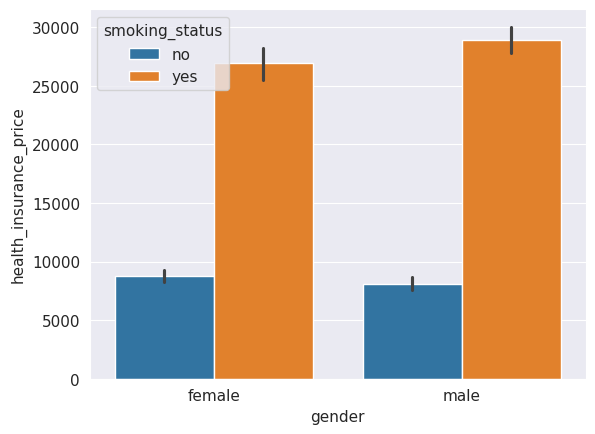

In [65]:
sns.barplot(data=df,x='gender',y='health_insurance_price',hue="smoking_status")


In [66]:
fig=px.histogram(df,x='gender',y = 'health_insurance_price',color = 'location')
fig.update_layout(bargap=0.1,width=600,height=400)
fig

Based on the observations we can clearly see that males occur high insurance cost compared to females.

the interesting thing found in exploration is that only females to occur high cost in comarison are the females of northwest location.

<Axes: >

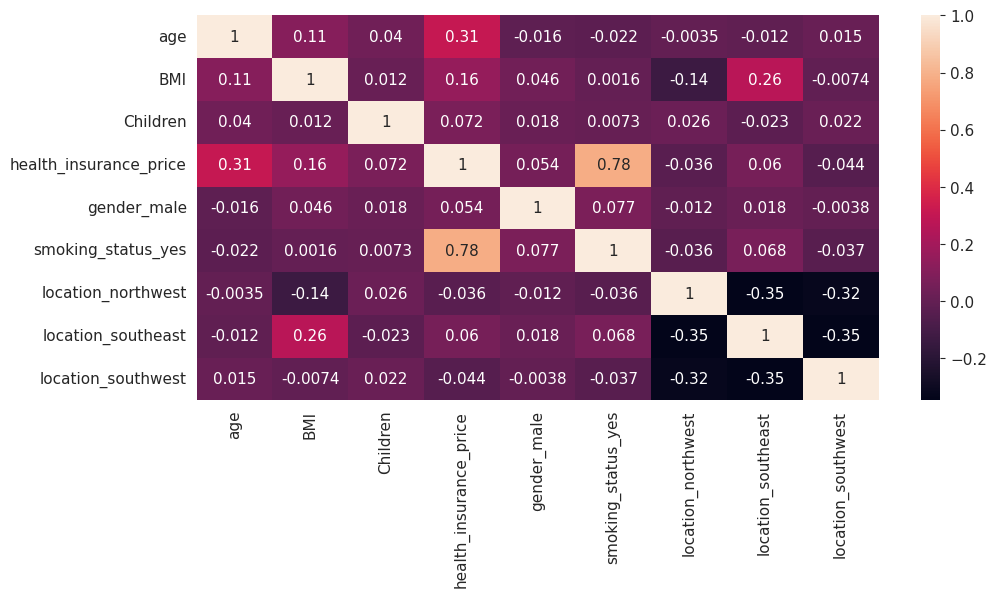

In [107]:
plt.figure(figsize=(11,5))
sns.heatmap(insur_df.corr(), annot=True)


From the heatmap we can conclude that age is the most important feature in determining health_insurance_price,followed up by bmi and the count of children per customer doesn't really has any impact on health_insurance_price

## **Machine learning 👨‍💻->🤖**

### **Feature Engineering ⚙️**

In [68]:
insur_df = df.copy().reset_index(drop=True)

In [69]:
insur_df.isnull().sum()

age                       0
gender                    0
BMI                       0
Children                  0
smoking_status            0
location                  0
health_insurance_price    0
dtype: int64

In [70]:
# converting categorical text data to numeric data

insur_df['smoking_status'].value_counts()

no     1063
yes     274
Name: smoking_status, dtype: int64

In [71]:
insur_df=pd.get_dummies(insur_df,columns=['gender','smoking_status','location'],drop_first=True) # removes multicollinearity
insur_df

,age,BMI,Children,health_insurance_price,gender_male,smoking_status_yes,location_northwest,location_southeast,location_southwest
0,19.0,24.760,0,16884.92400,0,1,0,0,1
1,18.0,33.770,1,1725.55230,1,0,0,1,0
2,28.0,33.000,3,4449.46200,1,0,0,1,0
3,33.0,22.705,0,21984.47061,1,0,1,0,0
4,32.0,28.880,0,3866.85520,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1332,50.0,30.970,3,10600.54830,1,0,1,0,0
1333,18.0,31.920,0,2205.98080,0,0,0,0,0
1334,18.0,36.850,0,1629.83350,0,0,0,1,0
1335,21.0,25.800,0,2007.94500,0,0,0,0,1


In [72]:
insur_df.isnull().sum()

age                       0
BMI                       0
Children                  0
health_insurance_price    0
gender_male               0
smoking_status_yes        0
location_northwest        0
location_southeast        0
location_southwest        0
dtype: int64

## **Model selection 🕵‍♀**

For a regression problem, suitable models include Linear Regression, Decision Trees, Random Forest, and XGBoost. These models can be implemented to predict health insurance prices.


In [73]:
features=insur_df[['age','BMI','Children','gender_male','smoking_status_yes']]
target=insur_df['health_insurance_price']

In [74]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
regressor=RandomForestRegressor(n_estimators=100)
selector=RFE(regressor,n_features_to_select=4)
new=selector.fit_transform(features,target)
idx_selec=selector.get_support(indices=True)
featur=features.columns[idx_selec]

**Cross validation technique 🗃️**

In [101]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(features,target,test_size=0.2,random_state=0)

## **Model Training and Evaluation 🏋️‍♂️ ⚖️**

In [102]:
# importing models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error


models={
   "lin_r":LinearRegression(),
   "DT":DecisionTreeRegressor(),
   "RF":RandomForestRegressor(n_estimators=100, max_depth=5),
   "SVR":SVR(),
   "XGB":XGBRegressor()
   }

for name,model in models.items():
  print(f"Model_name: {name}")
  model.fit(x_train, y_train)
  y_pred=model.predict(x_test)
  print(f"score_is                :{r2_score(y_test,y_pred)}")
  print(f"Mean_Squared_Error      :{mean_squared_error(y_test,y_pred)}")
  print(f"Root_Mean_Squared_Error :{np.sqrt(mean_squared_error(y_test,y_pred))}")
  print(f"Mean_Absolute_Error     :{mean_squared_error(y_test,y_pred)}")
  print("---------------------x----------------------")

Model_name: lin_r
score_is                :0.7112494328029109
Mean_Squared_Error      :33214439.52795601
Root_Mean_Squared_Error :5763.196988474019
Mean_Absolute_Error     :33214439.52795601
---------------------x----------------------
Model_name: DT
score_is                :0.6394353771042777
Mean_Squared_Error      :41475076.49713445
Root_Mean_Squared_Error :6440.1146338504295
Mean_Absolute_Error     :41475076.49713445
---------------------x----------------------
Model_name: RF
score_is                :0.7807766664987432
Mean_Squared_Error      :25216851.431237046
Root_Mean_Squared_Error :5021.638321428281
Mean_Absolute_Error     :25216851.431237046
---------------------x----------------------
Model_name: SVR
score_is                :-0.10640517297714558
Mean_Squared_Error      :127267724.76323491
Root_Mean_Squared_Error :11281.299781640186
Mean_Absolute_Error     :127267724.76323491
---------------------x----------------------
Model_name: XGB
score_is                :0.7390670244237

## **Hyperparameter Tuning 🛠**

In [103]:
# tuning the model for better model perfomance

from sklearn.model_selection import GridSearchCV

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
}

# Create an instance of XGBRegressor
xgb_model = XGBRegressor()

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='r2')

# Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best R-squared Score:", best_score)

# Use the best estimator for predictions
best_xgb_model = grid_search.best_estimator_
y_pred_best = best_xgb_model.predict(x_test)

# Evaluate the model with best parameters
print("Evaluation with Best Parameters:")
print("R-squared Score:", r2_score(y_test, y_pred_best))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_best))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred_best))


Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Best R-squared Score: 0.8071824634881837
Evaluation with Best Parameters:
R-squared Score: 0.7876203568388284
Mean Squared Error: 24429634.48771616
Root Mean Squared Error: 4942.6343671888335
Mean Absolute Error: 2883.5067521805036


In [104]:
# model tuning for random forest regressor
from sklearn.model_selection import GridSearchCV


# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 500, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create an instance of RandomForestRegressor
rf_model = RandomForestRegressor()

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='r2')

# Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best R-squared Score:", best_score)

# Use the best estimator for predictions
best_rf_model = grid_search.best_estimator_
y_pred_best = best_rf_model.predict(x_test)

# Evaluate the model with best parameters
print("\nEvaluation with Best Parameters:")
print("R-squared Score:", r2_score(y_test, y_pred_best))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_best))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred_best))


Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Best R-squared Score: 0.810412258932039

Evaluation with Best Parameters:
R-squared Score: 0.7858033977442012
Mean Squared Error: 24638635.905649554
Root Mean Squared Error: 4963.7320541755225
Mean Absolute Error: 2645.870368879139


## **conclusion 🔚**

After thorough analysis and model evaluation, the Random Forest model emerges as the preferred choice for predicting health insurance costs in this scenario,
and the **Random Forest** model **slightly outperforms** the XGBoost model.

**High-Impact Variables:**

**Smoking Status:**Smoking status exhibited the strongest positive correlation (0.78) with health insurance costs, indicating that smokers tend to have higher insurance costs.

**Age:** Age showed a moderately positive correlation (0.31) with insurance costs, suggesting that older individuals typically incur higher insurance expenses.

**BMI:** Body Mass Index (BMI) displayed a moderate positive correlation (0.16) with insurance costs, indicating that individuals with higher BMIs tend to have higher insurance expenses.

**Location's Insignificance:**

Removing the "location" variable from the analysis did not significantly impact the model's predictive performance. This suggests that geographical location may not be a major determinant of health insurance costs in the analyzed dataset.



In conclusion, the Random Forest model, leveraging insights from smoking status, age, and BMI, offers a robust framework for accurately predicting health insurance costs. Additionally, the insignificance of the "location" variable underscores the importance of focusing on other key predictors in modeling health insurance expenses.
